<a href="https://colab.research.google.com/github/JonatasLemos/DataAnalysisProjects/blob/main/capitalsCentralization/DistanceCitiesFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Centralization of Brazilian capitals

In [1]:
import pandas as pd
import numpy as np

In [2]:
cities_state = pd.read_feather("/content/drive/MyDrive/Colab Data/cities_states.feather")

In [3]:
cities_state

,INPUT_FID,NEAR_FID,DISTANCE,NAME,STATE
0,2,4499,8.323814,Belém/PA,PA
1,2,4429,7.498620,Belém/PA,PA
2,2,4112,6.748079,Belém/PA,PA
3,2,1352,6.844475,Belém/PA,PA
4,2,3419,8.927219,Belém/PA,PA
...,...,...,...,...,...
2209347,5558,585,2.471269,Zacarias/SP,SP
2209348,5558,570,1.892356,Zacarias/SP,SP
2209349,5558,569,1.563437,Zacarias/SP,SP
2209350,5558,352,2.460841,Zacarias/SP,SP


## Grouping by to obtain the distance sum per city

In [4]:
grouped = cities_state.groupby(['STATE','NAME'],observed=True)["DISTANCE"].sum().to_frame()
grouped

DISTANCE
STATE NAME                                
PA    Belém/PA                  443.691551
      Abaetetuba/PA             433.460174
      Abel Figueiredo/PA        537.196401
      Acará/PA                  439.464974
      Afuá/PA                   580.797326
...                                    ...
SP    Vista Alegre do Alto/SP  1346.019518
      Vitória Brasil/SP        1931.850123
      Votorantim/SP            1589.064454
      Votuporanga/SP           1706.172199
      Zacarias/SP              1532.684310

[5559 rows x 1 columns]

In [5]:
grouped.reset_index(inplace=True)
grouped.sort_values(by=['STATE','DISTANCE'],inplace=True,ignore_index=True)
grouped.index = np.arange(1, len(grouped["STATE"])+1)
grouped.to_csv("grouped.csv")
grouped

,STATE,NAME,DISTANCE
1,AC,Manoel Urbano/AC,49.142036
2,AC,Sena Madureira/AC,49.424210
3,AC,Santa Rosa do Purus/AC,50.737947
4,AC,Bujari/AC,50.782750
5,AC,Xapuri/AC,51.330168
...,...,...,...
5555,TO,Combinado/TO,572.708183
5556,TO,Aurora do Tocantins/TO,573.236533
5557,TO,Lavandeira/TO,574.482658
5558,TO,Novo Alegre/TO,585.779153


## Reading capitals sheet

In [6]:
capitals = pd.read_excel(f"/content/drive/MyDrive/Colab Data/output_distance.xls", sheet_name="Capitals")
capitals.drop(["Unnamed: 0","POPULAÇÃO ESTIMADA"],axis=1,inplace=True)
capitals.sort_values(by="STATE",inplace=True)
capitals.drop(capitals[capitals['NAME'] == "Brasília/DF"].index, inplace = True)
capitals.reset_index(inplace=True,drop=True)
capitals.head(3)

,NAME,STATE
0,Rio Branco/AC,AC
1,Maceió/AL,AL
2,Manaus/AM,AM


## Creating DF with centralization by capital

In [7]:
state_size = grouped["STATE"].value_counts().sort_index()
state_size.drop(labels=['DF'],inplace=True)
state_size.head(3)

AC     22
AL    102
AM     62
Name: STATE, dtype: int64

In [8]:
capital_position = []

def format_values(df,state_size):
  value = (df-state_size[0:i].sum())/state_size[i]
  return (round(1-value,2))*100

for i in range(len(capitals["NAME"])):
  select = grouped["NAME"] == capitals["NAME"][i]
  df = grouped[select].index[0]
  capital_position.append(format_values(df,state_size))

In [9]:
d = {'NAME': capitals["NAME"], '% Centralization': capital_position}

In [10]:
centralization = pd.DataFrame(data=d)
centralization.sort_values(by="% Centralization",ascending=False,inplace=True)
centralization["% of cities better centralized"] = 100-centralization["% Centralization"]
centralization.reset_index(inplace=True,drop=True)
centralization.head(6)

,NAME,% Centralization,% of cities better centralized
0,Belo Horizonte/MG,100.0,0.0
1,Belém/PA,90.0,10.0
2,Goiânia/GO,90.0,10.0
3,Palmas/TO,88.0,12.0
4,Boa Vista/RR,87.0,13.0
5,Campo Grande/MS,82.0,18.0


## Creating CSVs with the most and least centralized cities per state

In [11]:
min_selection = grouped["DISTANCE"].isin(grouped.groupby(["STATE"])["DISTANCE"].min())
grouped[min_selection].to_csv("most_centralized.csv")

In [12]:
max_selection = grouped["DISTANCE"].isin(grouped.groupby(["STATE"])["DISTANCE"].max())
grouped[max_selection].to_csv("least_centralized.csv")

## Ploting functions

In [13]:
import matplotlib.pyplot as plt
title_font = 20
label_font = 14
plt.rcParams["figure.figsize"] = [9, 6]

In [14]:
def title(*args):
  plt.title(args[0],fontsize=label_font)
  plt.xlabel(args[1],fontsize=label_font)
  plt.ylabel(args[2],fontsize=label_font)
  plt.xticks(fontsize=label_font)
  plt.yticks(fontsize=label_font)
  plt.grid(lw="0.2")
  plt.show()  
def plot_bar(*args,dispersion=False):
  plt.barh(args[0],args[1])
  if not dispersion:
    title(f'Capitais {args[2]} centralizadas','% de centralização','Capital')
  else:
    title(f'Estados com {args[2]} dispersão municipal','Coeficiente de variação','Estado')

## Ploting centralization 

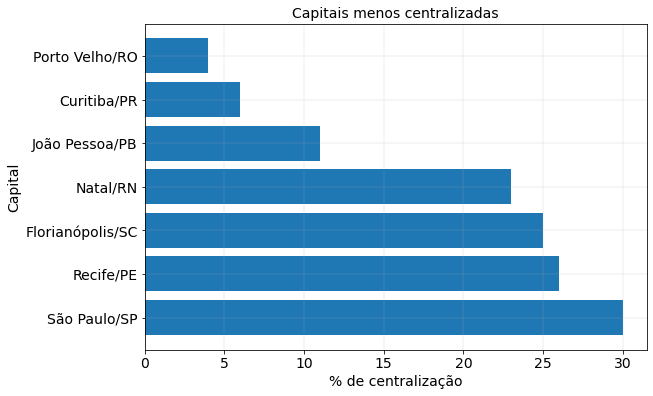

In [15]:
plot_bar(centralization["NAME"].tail(7),centralization["% Centralization"].tail(7),"menos")

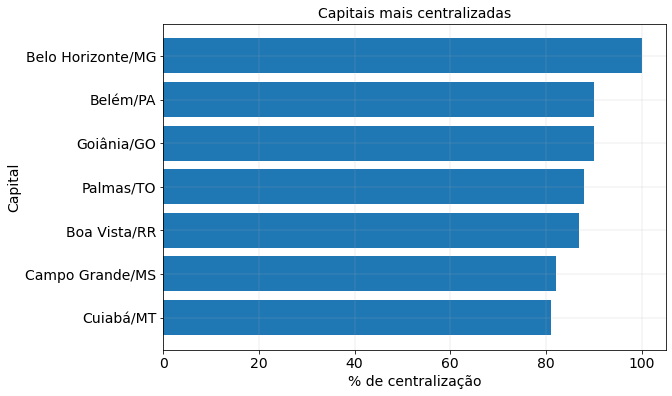

In [16]:
centralization.sort_values(by="% Centralization",ascending=True,inplace=True)
plot_bar(centralization["NAME"].tail(7),centralization["% Centralization"].tail(7),"mais")

## Aggregating DF to obtain, mean distance, std deviation and coefficiente of variation per state

In [17]:
grouped_agg = grouped.groupby(['STATE'],observed=True)["DISTANCE"].agg(["mean","std"])
grouped_agg["coefficient of variation"] = grouped_agg["std"]/grouped_agg["mean"]

In [18]:
grouped_agg.sort_values(by="coefficient of variation",inplace=True)
grouped_agg["STATE"] = grouped_agg.index
grouped_agg.reset_index(inplace=True,drop=True)
grouped_agg.head()

,mean,std,coefficient of variation,STATE
0,229.034223,36.913615,0.161171,RN
1,369.742808,60.599721,0.163897,CE
2,634.713805,106.437771,0.167694,SC
3,60.447004,10.841214,0.179351,AC
4,327.849465,59.221540,0.180636,PB


## Ploting dispersion

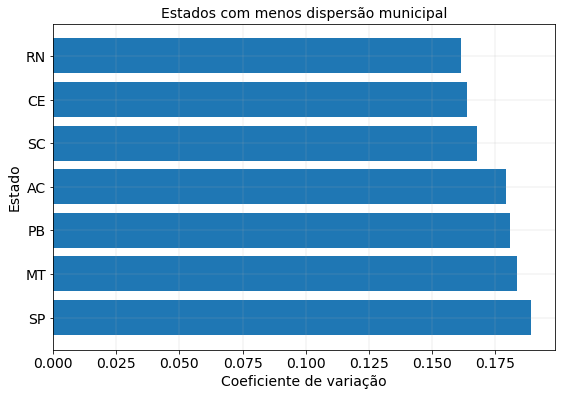

In [19]:
grouped_agg.sort_values(by="coefficient of variation",inplace=True,ascending=False)
plot_bar(grouped_agg["STATE"].tail(7),grouped_agg["coefficient of variation"].tail(7),"menos",dispersion=True)

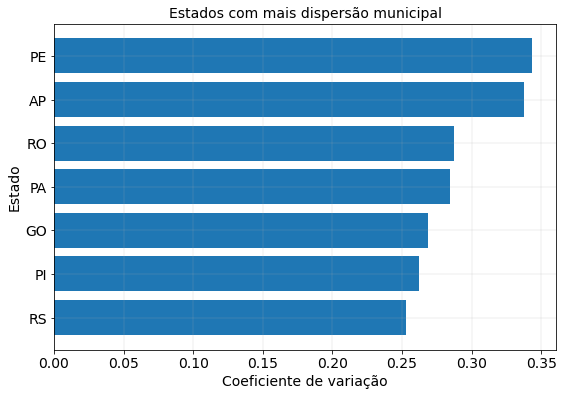

In [20]:
grouped_agg.sort_values(by="coefficient of variation",inplace=True,ascending=True)
plot_bar(grouped_agg["STATE"].tail(7),grouped_agg["coefficient of variation"].tail(7),"mais",dispersion=True)